## ALS Implementation
- This notebook |is implementation of ALS algorithm from "collaborative filtering for implicit dataset"

### Initialize parameters
- r_lambda: normalization parameter  
- alpha: confidence level  
- nf: dimension of latent vector of each user and item  
- initilzed values(40, 200, 40) are the best parameters from the paper

In [98]:
r_lambda = 40
nf = 200
alpha = 40

### Initialize original rating matrix data
- make sample (10 x 11) matrix
- 10 : num of users
- 11 : num of items

In [99]:
import numpy as np

# lambda: for normalization
# alpha: manipulating confidence level (1 + )
# 사용자와 아이템 각각의 


# 샘플로 사용할 사용자 평점 행렬 (10 x 11)
R = np.array([[0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0],
              [0, 3, 4, 0, 3, 0, 0, 2, 2, 0, 0],
              [0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5],
              [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4],
              [0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0],
              [0, 0, 0, 3, 0, 0, 0, 0, 4, 5, 0]])
print(R.shape)

(10, 11)


### Initialize user and item latent factor matrix
- nu: num of users (10)
- ni: num of items (11)
- nf: dimension of latent vector

In [100]:
nu = R.shape[0]
ni = R.shape[1]

# initialize X and Y with very small values
X = np.random.rand(nu, nf) * 0.01
Y = np.random.rand(ni, nf) * 0.01

print(X)

[[0.00457303 0.00424385 0.00616191 ... 0.0055276  0.00441167 0.0032725 ]
 [0.00197897 0.00110453 0.00558329 ... 0.00915551 0.00749223 0.006756  ]
 [0.00549164 0.00358061 0.00012187 ... 0.00723139 0.00441681 0.00632714]
 ...
 [0.00380493 0.005744   0.0024226  ... 0.00737873 0.00131759 0.00736437]
 [0.00115033 0.00066236 0.00046558 ... 0.00804704 0.00986983 0.00343679]
 [0.00504484 0.00616501 0.00130519 ... 0.00236188 0.00136329 0.00666413]]


### Initialize Binary Rating Matrix P
- Convert original rating matrix R into P
- Pui = 1 if Rui > 0
- Pui = 0 if Rui = 0

In [101]:
P = np.copy(R)
P[P > 0] = 1
print(P)

[[0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 1 1 0 1 0 0 1 1 0 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 1 0 0 0 0 1 1 0]]


### Initialize Confidence Matrix C
- Cui = 1 + alpha * Rui
- Cui means confidence level of certain rating data

In [102]:
C = 1 + alpha * R
print(C)

[[  1   1   1 161 161   1   1   1   1   1   1]
 [  1   1   1   1   1   1   1   1   1   1  41]
 [  1   1   1   1   1   1   1  41   1 161   1]
 [  1 121 161   1 121   1   1  81  81   1   1]
 [  1 201 201   1   1   1   1   1   1   1   1]
 [  1   1   1   1   1   1 201   1   1 201   1]
 [  1   1 161   1   1   1   1   1   1   1 201]
 [  1   1   1   1   1 161   1   1   1   1 161]
 [  1   1   1   1   1   1 201   1   1 201   1]
 [  1   1   1 121   1   1   1   1 161 201   1]]


### Set up loss function
- C: confidence matrix
- P: binary rating matrix
- X: user latent matrix
- Y: item latent matrix
- r_lambda: regularization lambda
- xTy: predict matrix  
  
- Total_loss = (confidence_level * predict loss) + regularization loss

In [103]:
def loss_function(C, P, xTy, X, Y, r_lambda):
    predict_error = np.square(P - xTy)
    confidence_error = np.sum(C * predict_error)
    regularization = r_lambda * (np.sum(np.square(X)) + np.sum(np.square(Y)))
    total_loss = confidence_error + regularization
    return np.sum(predict_error), confidence_error, regularization, total_loss

### Optimization Function for user and item
- X[u] = (yTCuy + lambda*I)^-1yTCuy
- Y[i] = (xTCix + lambda*I)^-1xTCix
- two formula is the same when it changes X to Y and u to i

In [104]:
def optimize_user(X, Y, C, P, nu, nf, r_lambda):
    yT = np.transpose(Y)
    for u in range(nu):
        Cu = np.diag(C[u])
        yT_Cu_y = np.matmul(np.matmul(yT, Cu), Y)
        lI = np.dot(r_lambda, np.identity(nf))
        yT_Cu_pu = np.matmul(np.matmul(yT, Cu), P[u])
        X[u] = np.linalg.solve(yT_Cu_y + lI, yT_Cu_pu)

def optimize_item(X, Y, C, P, ni, nf, r_lambda):
    xT = np.transpose(X)
    for i in range(ni):
        Ci = np.diag(C[:, i])
        xT_Ci_x = np.matmul(np.matmul(xT, Ci), X)
        lI = np.dot(r_lambda, np.identity(nf))
        xT_Ci_pi = np.matmul(np.matmul(xT, Ci), P[:, i])
        Y[i] = np.linalg.solve(xT_Ci_x + lI, xT_Ci_pi)

### Train
- usually ALS algorithm repeat train steps for 10 ~ 15 times

In [105]:
predict_errors = []
confidence_errors = []
regularization_list = []
total_losses = []

for i in range(15):
    if i!=0:   
        optimize_user(X, Y, C, P, nu, nf, r_lambda)
        optimize_item(X, Y, C, P, ni, nf, r_lambda)
    predict = np.matmul(X, np.transpose(Y))
    predict_error, confidence_error, regularization, total_loss = loss_function(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    regularization_list.append(regularization)
    total_losses.append(total_loss)
    
    print('----------------step %d----------------' % i)
    print("predict error: %f" % predict_error)
    print("confidence error: %f" % confidence_error)
    print("regularization: %f" % regularization)
    print("total loss: %f" % total_loss)
    
predict = np.matmul(X, np.transpose(Y))
print('final predict')
print([predict])

----------------step 0----------------
predict error: 22.767452
confidence error: 3466.937317
regularization: 5.636577
total loss: 3472.573894
----------------step 1----------------
predict error: 31.023025
confidence error: 296.327809
regularization: 641.240713
total loss: 937.568522
----------------step 2----------------
predict error: 34.018641
confidence error: 139.069458
regularization: 651.405197
total loss: 790.474655
----------------step 3----------------
predict error: 32.074433
confidence error: 120.069403
regularization: 650.898109
total loss: 770.967512
----------------step 4----------------
predict error: 29.512463
confidence error: 109.299027
regularization: 653.525673
total loss: 762.824700
----------------step 5----------------
predict error: 27.060229
confidence error: 102.230607
regularization: 656.474772
total loss: 758.705379
----------------step 6----------------
predict error: 25.016805
confidence error: 97.437625
regularization: 658.928086
total loss: 756.365710


<Figure size 432x288 with 0 Axes>

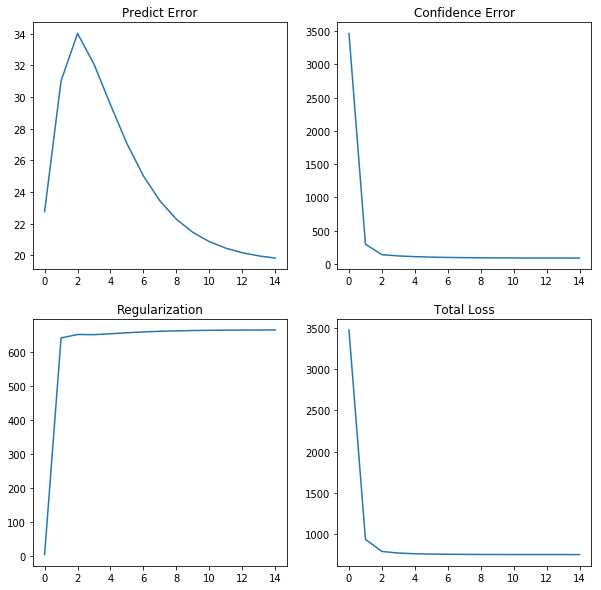

In [106]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplots_adjust(wspace=100.0, hspace=20.0)
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
predict_error_line = fig.add_subplot(2, 2, 1)
confidence_error_line = fig.add_subplot(2, 2, 2)
regularization_error_line = fig.add_subplot(2, 2, 3)
total_loss_line = fig.add_subplot(2, 2, 4)

predict_error_line.set_title("Predict Error") 
predict_error_line.plot(predict_errors)

confidence_error_line.set_title("Confidence Error")
confidence_error_line.plot(confidence_errors)

regularization_error_line.set_title("Regularization")
regularization_error_line.plot(regularization_list)

total_loss_line.set_title("Total Loss")
total_loss_line.plot(total_losses)
plt.show()